In [11]:
!pip install biopython

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from scipy.spatial.distance import pdist, squareform


In [5]:
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D',
    'CYS': 'C', 'GLN': 'Q', 'GLU': 'E', 'GLY': 'G',
    'HIS': 'H', 'ILE': 'I', 'LEU': 'L', 'LYS': 'K',
    'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S',
    'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
    'SEC': 'U', 'PYL': 'O', 'ASX': 'B', 'GLX': 'Z', 'XLE': 'J', 'UNK': 'X'
}


In [12]:
def load_amino_acid_properties(csv_path):
    df = pd.read_csv(csv_path)
    properties = {}
    for _, row in df.iterrows():
        aa = row['AA']
        properties[aa] = {
            'hydrophobicity': row['Hydrophobicity'],
            'molecular_weight': row['MolecularWeight'],
            'charge': row['Charge']
        }
    return properties


In [13]:
def extract_ca_coords_and_sequence(pdb_path, chain_id='A'):
    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("protein", pdb_path)
        model = structure[0]
        chain = model[chain_id]

        coords = []
        sequence = ""
        for residue in chain:
            if 'CA' in residue:
                ca = residue['CA'].get_coord()
                coords.append(ca)
                resname = residue.get_resname()
                aa = three_to_one.get(resname, 'X')
                sequence += aa

        return np.array(coords), sequence

    except KeyError:
        print(f"Chain '{chain_id}' not found in the PDB file.")
        return None, None
    except Exception as e:
        print("Error reading PDB:", e)
        return None, None



In [14]:
def build_spatial_graph(sequence, coords, feature_dict, distance_threshold=8.0):
    G = nx.Graph()

    for i, aa in enumerate(sequence):
        features = feature_dict.get(aa, {'hydrophobicity': 0, 'molecular_weight': 0, 'charge': 0})
        G.add_node(i, aa=aa, **features)

    dist_matrix = squareform(pdist(coords))

    for i in range(len(sequence)):
        for j in range(i + 1, len(sequence)):
            d = dist_matrix[i, j]
            if d <= distance_threshold:
                G.add_edge(i, j, weight=d)

    return G


In [15]:
def save_graph(graph, path_prefix="protein_graph"):
    # ذخیره به صورت گرافML (خوانا برای ابزارها مثل Gephi)
    nx.write_graphml(graph, f"{path_prefix}.graphml")

    # ذخیره به صورت باینری (برای استفاده راحت در پایتون)
    nx.write_gpickle(graph, f"{path_prefix}.gpickle")

    print("Graph saved successfully.")


In [16]:
def save_graph_image(G, filename="graph.png"):
    pos = nx.spring_layout(G, seed=42)
    hydros = [G.nodes[n]['hydrophobicity'] for n in G.nodes]

    plt.figure(figsize=(12, 8))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=hydros, cmap='coolwarm', node_size=100)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.colorbar(nodes, label='Hydrophobicity')
    plt.title("Spatial Graph - Hydrophobicity")
    plt.axis('off')
    plt.savefig(filename, dpi=300)
    plt.close()



In [17]:
def show_graph_by_hydrophobicity(G, title="Spatial Graph - Hydrophobicity"):
    pos = nx.spring_layout(G, seed=42)
    hydros = [G.nodes[n]['hydrophobicity'] for n in G.nodes]

    plt.figure(figsize=(12, 8))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=hydros, cmap='coolwarm', node_size=100)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.colorbar(nodes, label='Hydrophobicity')
    plt.title(title)
    plt.axis('off')
    plt.show()


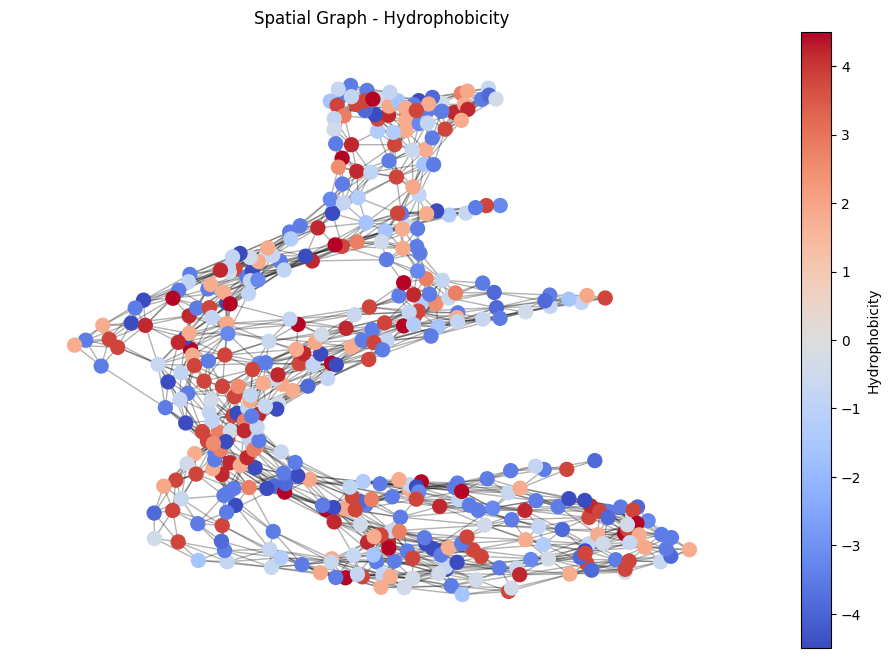

In [18]:
show_graph_by_hydrophobicity(graph)
save_graph_image(graph)


گره‌ها: 434
یال‌ها: 2065


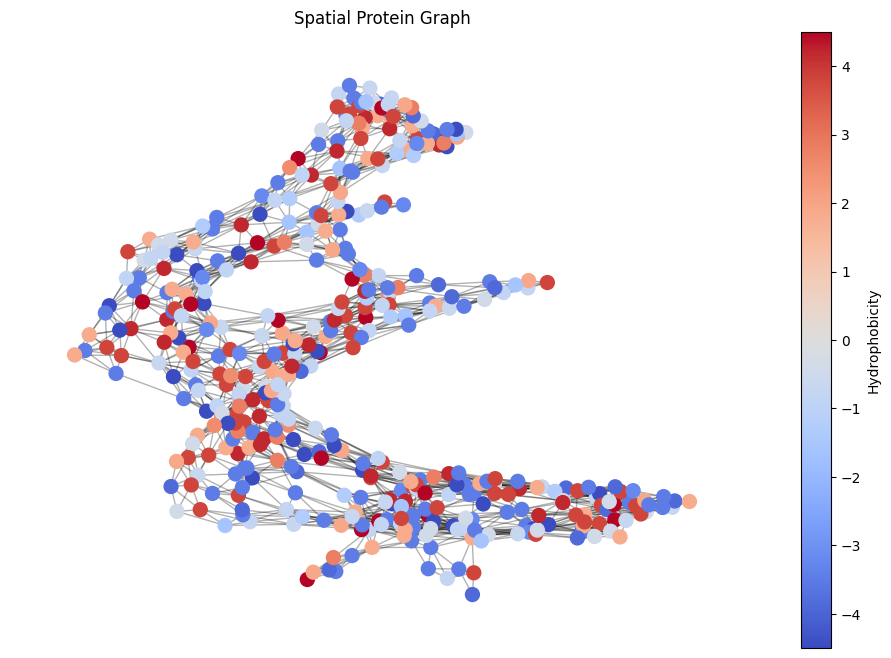

In [21]:
# تنظیم مسیرها
pdb_path = "/content/drive/MyDrive/0to4846/1AOS.pdb"
csv_path = "/content/drive/MyDrive/GitHub/ProtGraph/data/Amino_Acid_Properties.csv"

# بارگذاری داده‌ها
amino_acid_properties = load_amino_acid_properties(csv_path)
coords, sequence = extract_ca_coords_and_sequence(pdb_path)
graph = build_spatial_graph(sequence, coords, amino_acid_properties, distance_threshold=8.0)

# چاپ اطلاعات و نمایش گراف
print("گره‌ها:", graph.number_of_nodes())
print("یال‌ها:", graph.number_of_edges())
visualize_graph_by_hydrophobicity(graph)
